# 4장. GEE를 활용한 위성기반 식생변화 분석

## 4.2. 설악산국립공원 식생지수 분석

In [ ]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
from ipyleaflet import TileLayer
from google.colab import files

# Earth Engine 인증
ee.Authenticate()

# Earth Engine 초기화
ee.Initialize(project='ee-kimrudfhr')

### 4.2.1. 설악산국립공원 경계 추출

In [ ]:
# 설악산국립공원 경계 추출
wdpa = ee.FeatureCollection("WCMC/WDPA/current/polygons")
seoraksan = wdpa.filter(ee.Filter.eq('WDPAID', 768))

# 선택된 보호지역 이름 확인
wdpa_name = seoraksan.first().get('NAME').getInfo()
print("Name:", wdpa_name)

Name: Seoraksan


In [ ]:
# Vworld 배경지도 객체
vworld_base = TileLayer(
    url='https://xdworld.vworld.kr/2d/Base/service/{z}/{x}/{y}.png',
    name='Vworld Base', attribution='Vworld',
)

# 설악산국립공원 경계
m = geemap.Map(width="800px", height="400px")
m.add_layer(vworld_base)
m.addLayer(seoraksan, {'color': 'green'}, wdpa_name)
m.centerObject(seoraksan, 11)
m

Map(center=[38.13586631470285, 128.41252722579236], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
import requests
import json

# GitHub 파일 다운로드
url = 'https://github.com/osgeokr/GEE-PAM-Book/raw/main/SEORAKSAN.geojson'
response = requests.get(url)
print(response.status_code)

geojson = response.json()
print(geojson)

# GeoJSON 데이터를 ee.FeatureCollection으로 변환
seoraksan = ee.FeatureCollection(geojson)
print(seoraksan.getInfo())

200
{'type': 'FeatureCollection', 'name': 'SEORAKSAN', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}, 'features': [{'type': 'Feature', 'properties': {'fid': 1, 'OBJECTID': 9, 'PARK_CODE': '04', 'KOR_NM': '���ǻ걹������', 'ENG_NM': 'Seoraksan National Park'}, 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[128.45301207300017, 38.26209159591779], [128.4530435360001, 38.262014484917806], [128.45307383800014, 38.26190085191779], [128.45309304200018, 38.26167611591778], [128.45312211600012, 38.26154898591778], [128.4531675050001, 38.26145055191775], [128.45331650300008, 38.26125607191776], [128.45336008200013, 38.26115919291775], [128.45339016500017, 38.260997287917796], [128.4533932620002, 38.2607497069178], [128.4533998270001, 38.26071442291777], [128.45340755700016, 38.26067282691776], [128.45342534300016, 38.26064451091777], [128.45343657200021, 38.26062661791777], [128.4536387690001, 38.260424470917805], [128.45370912200016, 38.26032273891778], 

### 4.2.2. Sentinel-2 이미지 선택 및 필터링

In [ ]:
def mask_s2_clouds(image):
    # QA(Quality Assurance) 밴드 사용, S2에서 구름 마스킹
    qa = image.select('QA60')

    # 비트 10은 구름(clouds), 11은 성층운(cirrus)
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11

    # 구름과 성층운이 0이면 맑은 상태로 간주함.
    mask = (
        qa.bitwiseAnd(cloud_bit_mask)
        .eq(0)
        .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    )

    return image.updateMask(mask).divide(10000) # 스케일링

In [ ]:
# Sentinel-2 이미지 선택 및 필터링
s2_images = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate("2024-01-01", "2024-01-31")
    .filterBounds(seoraksan)
    # 구름이 5% 미만인 이미지 필터링
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 5))
    .map(mask_s2_clouds)
)

# 이미지 컬렉션의 이미지 개수 확인
image_count = s2_images.size()

# 이미지 개수 출력
print("Image count:", image_count.getInfo())

Image count: 4


In [ ]:
# 중간값 이미지 계산
s2_image = s2_images.median()

In [ ]:
# TCC
vis_params = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

m = geemap.Map(width="800px", height="400px")
m.add_layer(s2_image, vis_params, 'TCC')
m.centerObject(seoraksan, 11)
m

Map(center=[38.136218061277916, 128.41248414920196], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
# FCC
vis_params = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B8', 'B4', 'B3'],
}

m = geemap.Map(width="800px", height="400px")
m.add_layer(s2_image, vis_params, 'FCC')
m.centerObject(seoraksan, 11)
m

Map(center=[38.136218061277916, 128.41248414920196], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
# 밴드 이름 목록
band_names = s2_image.bandNames()
print(band_names.getInfo())

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE']


In [ ]:
# B3, B4, B8 밴드 선택
fcc_image = s2_image.select(['B3', 'B4', 'B8']).clip(seoraksan.geometry())

In [ ]:
import time

# 이미지를 Google Drive에 내보내기
task = ee.batch.Export.image.toDrive(
    image=fcc_image,
    description='S2_FCC_202401',
    folder='export',
    scale=10,  # 이미지의 해상도
    region=seoraksan.geometry(),  # 내보낼 영역
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)

# 내보내기 작업 시작
task.start()

# 내보내기 작업 상태 확인
print('Export task started. Checking status...')

while True:
    status = task.status()
    state = status['state']
    print('Polling for task (id: {}). Status: {}'.format(task.id, state))
    if state in ['COMPLETED', 'FAILED']:
        break
    time.sleep(30)  # 30초 간격으로 상태 확인

# 완료 후 상태 출력
print('Task completed. Final status:')
print(status)

Export task started. Checking status...
Polling for task (id: GZUJDUX3434C7GB4LU5FJQCI). Status: READY
Polling for task (id: GZUJDUX3434C7GB4LU5FJQCI). Status: RUNNING
Polling for task (id: GZUJDUX3434C7GB4LU5FJQCI). Status: RUNNING
Polling for task (id: GZUJDUX3434C7GB4LU5FJQCI). Status: RUNNING
Polling for task (id: GZUJDUX3434C7GB4LU5FJQCI). Status: RUNNING
Polling for task (id: GZUJDUX3434C7GB4LU5FJQCI). Status: RUNNING
Polling for task (id: GZUJDUX3434C7GB4LU5FJQCI). Status: RUNNING
Polling for task (id: GZUJDUX3434C7GB4LU5FJQCI). Status: RUNNING
Polling for task (id: GZUJDUX3434C7GB4LU5FJQCI). Status: RUNNING
Polling for task (id: GZUJDUX3434C7GB4LU5FJQCI). Status: RUNNING
Polling for task (id: GZUJDUX3434C7GB4LU5FJQCI). Status: RUNNING
Polling for task (id: GZUJDUX3434C7GB4LU5FJQCI). Status: COMPLETED
Task completed. Final status:
{'state': 'COMPLETED', 'description': 'S2_FCC_202401', 'priority': 100, 'creation_timestamp_ms': 1742526983731, 'update_timestamp_ms': 1742527295459, 

### 4.2.3. 국립공원 경계 내에서 NDVI 계산 및 통계치 산출

In [ ]:
# NDVI 계산: (NIR - Red) / (NIR + Red)
ndvi = s2_image.normalizedDifference(['B8', 'B4'])

In [ ]:
# NDVI 색상 팔레트 정의
ndvi_palette = [
    'FE8374',  # 낮은 NDVI - 갈색
    'FED976',  # 낮은-중간 NDVI - 밝은 녹색
    'CAE23C',  # 중간 NDVI - 녹색
    '98B718',  # 중간-높은 NDVI - 진한 녹색
    '059033',  # 높은 NDVI - 매우 진한 녹색
]

# Vworld 하이브리드지도 객체
vworld_hybrid = TileLayer(
    url='https://xdworld.vworld.kr/2d/Hybrid/service/{z}/{x}/{y}.png',
    name='Vworld Hybrid',
    attribution='Vworld',
)

m = geemap.Map(width="800px", height="400px")
m.add_layer(ndvi, {'min': 0, 'max': 0.5, 'palette': ndvi_palette}, 'NDVI')
m.add_layer(vworld_hybrid)
m.centerObject(seoraksan, 11)
m

Map(center=[38.136218061277916, 128.41248414920196], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
# NDVI 통계치 계산 (최소값, 평균, 중간값, 최대값, 표준편차)
stats = ndvi.reduceRegion(
    reducer=ee.Reducer.min()
    .combine(reducer2=ee.Reducer.mean(), sharedInputs=True)
    .combine(reducer2=ee.Reducer.median(), sharedInputs=True)
    .combine(reducer2=ee.Reducer.max(), sharedInputs=True)
    .combine(reducer2=ee.Reducer.stdDev(), sharedInputs=True),
    geometry=seoraksan.geometry(),
    scale=10,
    maxPixels=1e9,
)

# 통계치 결과를 DataFrame으로 변환
df_stats = pd.DataFrame(
    [stats.getInfo()],
    columns=["nd_min", "nd_mean", "nd_median", "nd_max", "nd_stdDev"],
    index=["Seoraksan"],
)
df_stats.columns = ["Min", "Mean", "Median", "Max", "StdDev"]
df_stats

,Min,Mean,Median,Max,StdDev
Seoraksan,-0.352342,0.235699,0.18359,1,0.195743


In [ ]:
# DataFrame을 CSV 파일로 저장하기
df_stats.to_csv('df_stats.csv', index=True)
files.download('df_stats.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 4.3. 설악산생물권보전지역 산림손실 분석



In [ ]:
import ee
import geemap
from ipyleaflet import TileLayer
import pandas as pd
import matplotlib.pyplot as plt

# Earth Engine 인증
ee.Authenticate()

# Earth Engine 초기화
ee.Initialize(project='my-project')

### 4.3.1. 설악산 생물권보전지역 경계 추출

In [ ]:
# 설악산 생물권보전지역 경계 추출
wdpa = ee.FeatureCollection("WCMC/WDPA/current/polygons")
seorak = wdpa.filter(ee.Filter.eq('WDPAID', 5085))

# 선택된 보호지역의 이름 확인
wdpa_name = seorak.first().get('NAME').getInfo()
print("Name:", wdpa_name)

Name: Mount Sorak


In [ ]:
# 1: 외곽선의 픽셀 값, 2: 외곽선의 두께(픽셀 단위)
wdpa_raster = ee.Image().paint(seorak, 1, 2)

# 시각화 파라미터 설정
wdpa_vis = {
    'palette': ['#FFFF00'], # Yellow 색상 적용
    'opacity': 1
}

# Vworld 영상지도 객체
vworld_satellite = TileLayer(
    url='https://xdworld.vworld.kr/2d/Satellite/service/{z}/{x}/{y}.jpeg',
    name='Vworld Satellite',
    attribution='Vworld'
)

# 설악산 생물권보전지역 경계 가시화
m = geemap.Map(width="800px", height="500px")
m.add_layer(vworld_satellite)
m.addLayer(wdpa_raster, wdpa_vis, wdpa_name) # 레이어 추가
m.centerObject(seorak, 10) # 지도의 중심 설정
m # 지도 객체 출력

Map(center=[38.121201950409365, 128.4049622752154], controls=(WidgetControl(options=['position', 'transparent_…

### 4.3.2. 산림변화 데이터셋 사용

In [ ]:
# Hansen Global Forest Change v1.10 (2000-2022) 데이터셋
gfc = ee.Image('UMD/hansen/global_forest_change_2022_v1_10')

# 수관피복 시각화 파라미터
tree_cover_vis = {
    'bands': ['treecover2000'],
    'min': 0,
    'max': 100,
    'palette': ['black', 'green']
}

# 산림손실 시각화 파라미터
tree_loss_vis = {
    'bands': ['lossyear'],
    'min': 0,
    'max': 23,
    'palette': ['yellow', 'red']
}

In [ ]:
# Global Forest Change(GFC) 레이어 추가
m = geemap.Map(width="800px", height="400px")
m.addLayer(gfc, tree_cover_vis, 'tree cover')
m.addLayer(gfc, tree_loss_vis, 'tree loss year')
m.addLayer(wdpa_raster, wdpa_vis, wdpa_name)
m.add_layer(vworld_hybrid)
m.centerObject(seorak, 10) # 지도의 중심 설정
m # 지도 객체 출력

Map(center=[38.121201950409365, 128.4049622752154], controls=(WidgetControl(options=['position', 'transparent_…

### 4.3.3 산림 변화 비교

In [ ]:
# first 시각화 파라미터
first_vis = {
    'bands': ['first_b50', 'first_b40', 'first_b30']
}

# last 시각화 파라미터
last_vis = {
    'bands': ['last_b50', 'last_b40', 'last_b30']
}

# 분할-패널 지도(Split-panel map)
m = geemap.Map(width="800px", height="500px")

left_layer = geemap.ee_tile_layer(gfc, first_vis, "first")
right_layer = geemap.ee_tile_layer(gfc, last_vis, "last")
m.split_map(left_layer, right_layer)
m.centerObject(seorak, 11) # 지도의 중심 설정
m # 지도 객체 출력

Map(center=[38.121201950409365, 128.4049622752154], controls=(ZoomControl(options=['position', 'zoom_in_text',…

### 4.3.4. 산림손실 면적 계산 및 시각화

In [ ]:
# 산림손실 이미지
loss_image = gfc.select(['loss'])
area_image = loss_image.multiply(ee.Image.pixelArea())

# 설악산 BR 내 산림손실 면적 합산
stats = area_image.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=seorak.geometry(),
    scale=30,
    maxPixels=1e9,
)

# 산림손실 면적 출력
loss_area = stats.get('loss').getInfo()
print(f"산림손실 면적: {loss_area:.2f}m²")

산림손실 면적: 17368422.44m²


In [ ]:
# 산림손실연도 이미지
lossyear_image = gfc.select(['lossyear'])

# 2001-2022년 산림손실 면적 계산
years = range(1, 23)
loss_areas = []

for year in years:
    # 해당 연도의 산림손실 픽셀 선택
    yearly_loss = lossyear_image.eq(year)

    # 산림손실 면적 계산
    area_image = yearly_loss.multiply(ee.Image.pixelArea())
    stats = area_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=seorak.geometry(),
        scale=30,
        maxPixels=1e9,
    )

    # 연도별 손실 면적을 리스트에 추가 (단위: 제곱미터)
    loss_area = stats.getInfo()['lossyear']
    loss_areas.append(loss_area)

# 연도와 손실 면적을 데이터프레임으로 변환
    df = pd.DataFrame({
    'Year': range(2001, 2023),
    'Loss_Area_m2': loss_areas
})

df['Loss_Area_ha'] = df['Loss_Area_m2'] / 10000
df.head(1)

,Year,Loss_Area_m2,Loss_Area_ha
0,2001,200388.253457,20.038825


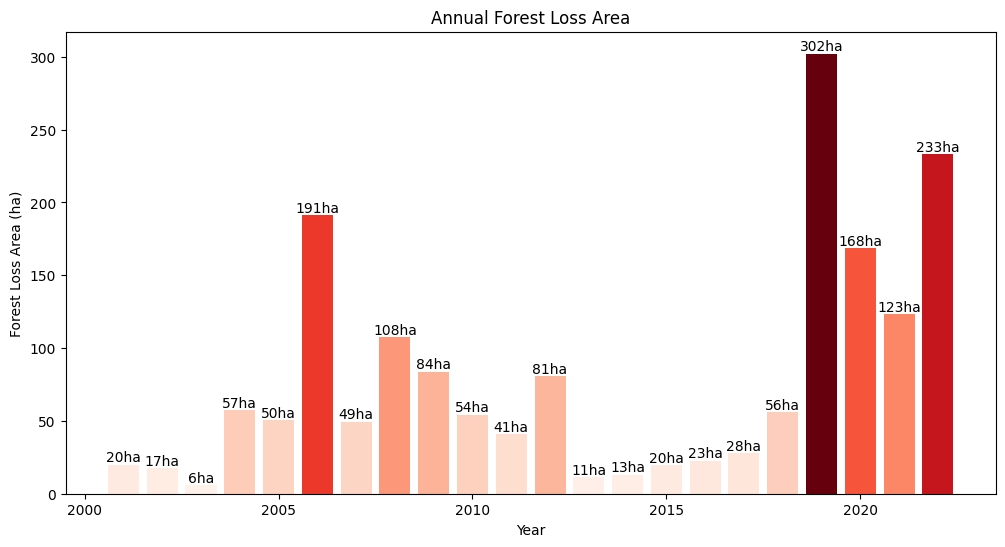

In [ ]:
# 연도별 산림손실 면적 막대 그래프 생성
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.Reds(df['Loss_Area_ha'] / df['Loss_Area_ha'].max())
bars = ax.bar(df['Year'], df['Loss_Area_ha'], color=colors)

# 막대 위에 헥타르 단위로 면적 표시
for bar, area_ha in zip(bars, df['Loss_Area_ha']):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{area_ha:.0f}ha', va='bottom', ha='center', color='black')

# 레이블 설정
ax.set_xlabel('Year')
ax.set_ylabel('Forest Loss Area (ha)')
ax.set_title('Annual Forest Loss Area')

# 차트를 이미지로 저장
plt.savefig('forest_loss_area_colored.png', dpi=100)
plt.show()